**Installation and Setup**

In [ ]:
!pip -q install textblob nltk vaderSentiment wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('vader_lexicon')

# Plot defaults
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**1) Load Your Data**

In [ ]:
from google.colab import files

# Upload the CSV you downloaded from here
uploaded = files.upload()   # <-- this will open a file picker
csv_path = list(uploaded.keys())[0]  # get the uploaded file name

# Load into pandas
df = pd.read_csv(csv_path)
df.head()

Saving sample_event_feedback.csv to sample_event_feedback.csv


,Timestamp,EventName,Department,YearOfStudy,OverallSatisfaction,Organization,Speakers,Activities,Venue,Food,WouldRecommend,WillAttendAgain,BestPart,ImprovementSuggestions,AnyOtherFeedback
0,2023-08-01 10:00:00,TechFest,CSE,2nd Year,5,5,4,5,4,5,Yes,Yes,Great event,Food was cold,Really enjoyed
1,2023-08-02 11:15:00,Cultural Day,ECE,1st Year,4,4,3,4,5,4,Yes,Yes,Well organized,Speakers were boring,NaN
2,2023-08-03 09:30:00,Workshop on AI,ME,3rd Year,3,3,4,3,3,2,No,No,Good experience,Food was limited,Could be better
3,2023-08-04 14:20:00,Sports Meet,Civil,2nd Year,5,5,5,5,4,5,Yes,Yes,Excellent work,Timing was late,Great event
4,2023-08-05 15:45:00,TechFest,MBA,1st Year,2,2,3,2,2,2,No,No,Bad experience,Speakers too long,Not on time


In [ ]:
print(df.shape)
print(df.columns.tolist())
df.sample(3)


(20, 15)
['Timestamp', 'EventName', 'Department', 'YearOfStudy', 'OverallSatisfaction', 'Organization', 'Speakers', 'Activities', 'Venue', 'Food', 'WouldRecommend', 'WillAttendAgain', 'BestPart', 'ImprovementSuggestions', 'AnyOtherFeedback']


,Timestamp,EventName,Department,YearOfStudy,OverallSatisfaction,Organization,Speakers,Activities,Venue,Food,WouldRecommend,WillAttendAgain,BestPart,ImprovementSuggestions,AnyOtherFeedback
16,2023-08-17 09:45:00,TechFest,ECE,3rd Year,4,4,5,4,4,5,Yes,Yes,Speakers were inspiring,Better sound system,Great event
2,2023-08-03 09:30:00,Workshop on AI,ME,3rd Year,3,3,4,3,3,2,No,No,Good experience,Food was limited,Could be better
19,2023-08-20 14:40:00,Sports Meet,MBA,3rd Year,4,4,4,4,4,3,Yes,Yes,Really enjoyed,Snacks variety less,Well organized


**2) Clean & Normalize Columns**

In [ ]:
# Make column names simple: no spaces, CamelCase → snake_case
df.columns = (
    df.columns.str.strip()
              .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
              .str.strip('_')
              .str.lower()
)

# Try to parse common date columns if present
for col in ['timestamp','eventdate','date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               20 non-null     datetime64[ns]
 1   eventname               20 non-null     object        
 2   department              20 non-null     object        
 3   yearofstudy             20 non-null     object        
 4   overallsatisfaction     20 non-null     int64         
 5   organization            20 non-null     int64         
 6   speakers                20 non-null     int64         
 7   activities              20 non-null     int64         
 8   venue                   20 non-null     int64         
 9   food                    20 non-null     int64         
 10  wouldrecommend          20 non-null     object        
 11  willattendagain         20 non-null     object        
 12  bestpart                20 non-null     object      

Handle Likert mapping

In [ ]:
likert_map = {
    'very dissatisfied':1,'dissatisfied':2,'neutral':3,'satisfied':4,'very satisfied':5,
    'strongly disagree':1,'disagree':2,'neutral':3,'agree':4,'strongly agree':5
}
for col in ['overallsatisfaction','organization','speakers','activities','venue','food']:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.lower().map(likert_map).fillna(pd.to_numeric(df[col], errors='coerce'))

In [ ]:
for col in ['wouldrecommend','willattendagain']:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.strip().str.lower().map({'yes':1,'no':0})


Remove exact duplicates & trim whitespace

In [ ]:
before = df.shape[0]
df = df.drop_duplicates()
for tcol in df.select_dtypes(include='object').columns:
    df[tcol] = df[tcol].astype(str).str.strip()
after = df.shape[0]
print(f"Removed {before-after} duplicate rows.")


Removed 0 duplicate rows.


In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,20,2023-08-11 00:59:30.000000256,2023-08-01 10:00:00,2023-08-06 07:45:00,2023-08-11 01:15:00,2023-08-15 18:58:45,2023-08-20 14:40:00,NaN
overallsatisfaction,20.0,3.85,2.0,3.0,4.0,5.0,5.0,1.089423
organization,20.0,3.85,2.0,3.0,4.0,5.0,5.0,1.089423
speakers,20.0,3.85,2.0,3.0,4.0,5.0,5.0,1.03999
activities,20.0,3.75,2.0,3.0,4.0,4.25,5.0,1.019546
venue,20.0,3.8,2.0,3.0,4.0,4.25,5.0,0.951453
food,20.0,3.7,2.0,2.75,4.0,5.0,5.0,1.260743
wouldrecommend,20.0,0.65,0.0,0.0,1.0,1.0,1.0,0.48936
willattendagain,20.0,0.65,0.0,0.0,1.0,1.0,1.0,0.48936


In [ ]:
print(df.columns.tolist())

['timestamp', 'eventname', 'department', 'yearofstudy', 'overallsatisfaction', 'organization', 'speakers', 'activities', 'venue', 'food', 'wouldrecommend', 'willattendagain', 'bestpart', 'improvementsuggestions', 'anyotherfeedback']


In [ ]:
df.columns = df.columns.str.strip().str.replace(" ", "", regex=False)
print(df.columns.tolist())

['timestamp', 'eventname', 'department', 'yearofstudy', 'overallsatisfaction', 'organization', 'speakers', 'activities', 'venue', 'food', 'wouldrecommend', 'willattendagain', 'bestpart', 'improvementsuggestions', 'anyotherfeedback']


In [ ]:
likert_cols = ["overallsatisfaction","organization","speakers","activities","venue","food"]

**3) Expolatory Data Analysis(EDA)**
    
     * Overall satisfaction distribution

/tmp/ipython-input-3553373561.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overallsatisfaction', data=df , palette="Blues")


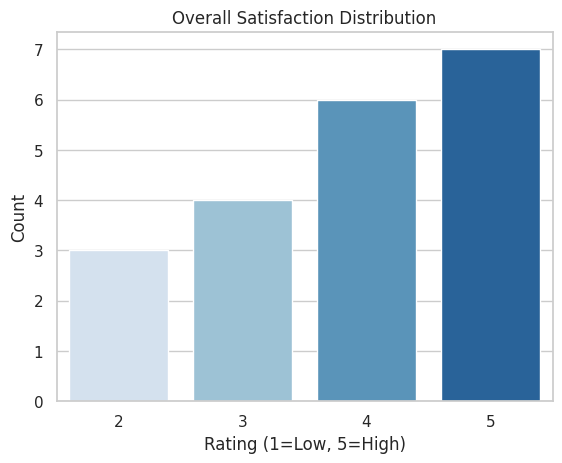

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.countplot(x='overallsatisfaction', data=df , palette="Blues")
plt.title('Overall Satisfaction Distribution')
plt.xlabel('Rating (1=Low, 5=High)')
plt.ylabel('Count')
plt.show()




 * Correlation between aspects

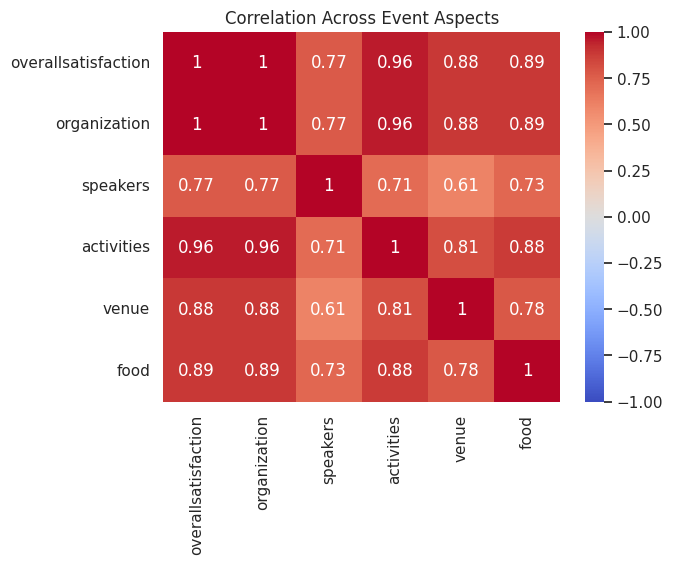

In [ ]:
plt.figure()
sns.heatmap(df[likert_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Across Event Aspects')
plt.show()

 * Average rating by category

/tmp/ipython-input-2061248996.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette="muted")


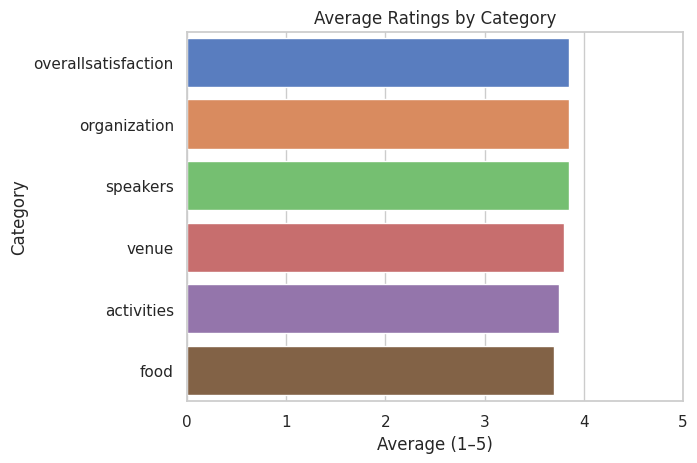

In [ ]:
avg_scores = df[likert_cols].mean().sort_values(ascending=False)
plt.figure()
sns.barplot(x=avg_scores.values, y=avg_scores.index, palette="muted")
plt.title('Average Ratings by Category')
plt.xlabel('Average (1–5)')
plt.ylabel('Category')
plt.xlim(0,5)
plt.show()

**4) Sentiment Analysis**

In [ ]:
text_cols = [c for c in ['bestpart','improvementsuggestions','anyotherfeedback','feedback','comments'] if c in df.columns]
df['free_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

df["SentimentScore"] = df["free_text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"


df["Sentiment"] = df["SentimentScore"].apply(label_sentiment)
df["Sentiment"].value_counts()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,count
Sentiment,
Positive,14
Negative,6


**Sentiment Distribution Plot**

/tmp/ipython-input-2435062075.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_vader', data=df, order=['positive','neutral','negative'] , palette="Set2")


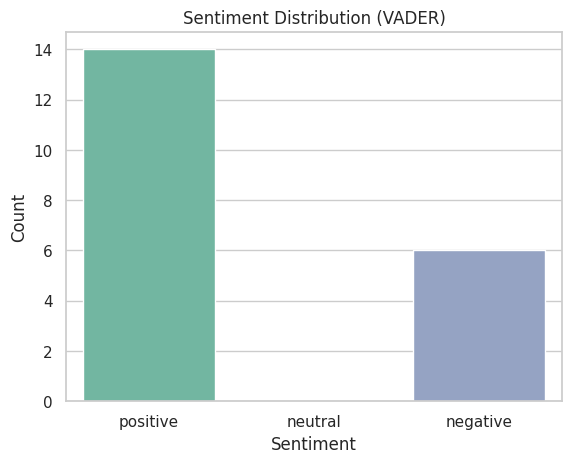

In [ ]:
plt.figure()
sns.countplot(x='sentiment_vader', data=df, order=['positive','neutral','negative'] , palette="Set2")
plt.title('Sentiment Distribution (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


**5) Frequent Themes & Word Cloud**

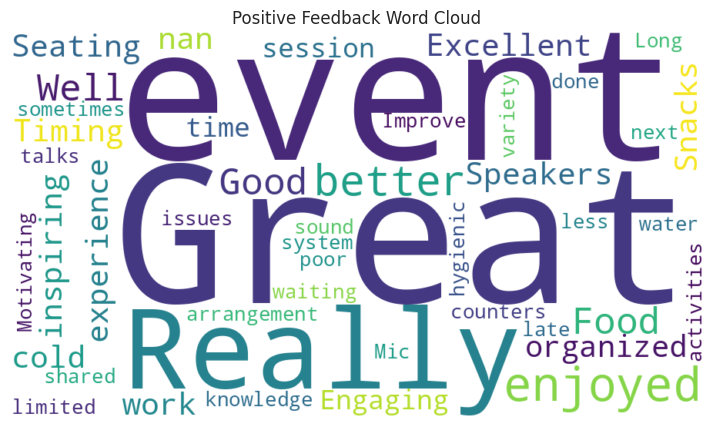

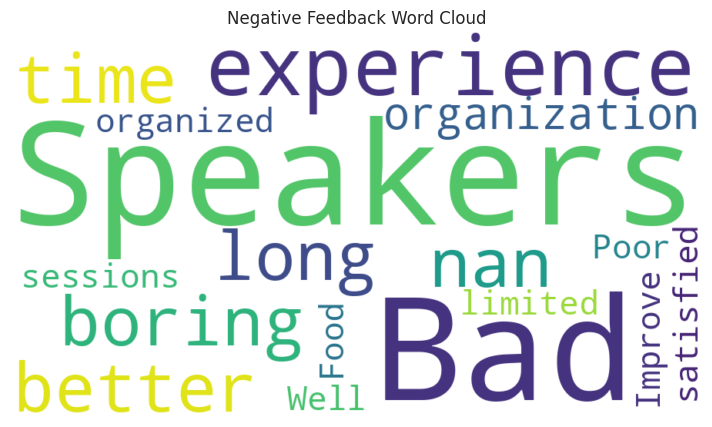

In [ ]:
def show_wordcloud(text, title):
    wc = WordCloud(width=900, height=500, background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off'); plt.title(title); plt.show()

# Positive vs Negative text pools
pos_text = ' '.join(df.loc[df['sentiment_vader']=='positive','free_text'].astype(str))
neg_text = ' '.join(df.loc[df['sentiment_vader']=='negative','free_text'].astype(str))

if len(pos_text.strip())>0: show_wordcloud(pos_text, 'Positive Feedback Word Cloud')
if len(neg_text.strip())>0: show_wordcloud(neg_text, 'Negative Feedback Word Cloud')


**6) Satisfaction trends (by event / date / segment)**

      i) By EventName

,overallsatisfaction,organization,speakers,activities,venue,food,vader_compound,vader_compound,vader_compound,vader_compound,vader_compound
eventname,,,,,,,,,,,
Workshop on AI,4.0,4.0,4.2,3.6,4.2,3.6,0.40,0.40,0.40,0.40,0.40
Cultural Day,3.8,3.8,3.4,3.8,4.0,3.4,0.29,0.29,0.29,0.29,0.29
Sports Meet,3.8,3.8,3.8,3.8,3.4,3.6,0.36,0.36,0.36,0.36,0.36
TechFest,3.8,3.8,4.0,3.8,3.6,4.2,0.43,0.43,0.43,0.43,0.43


/tmp/ipython-input-588144894.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='overallsatisfaction', y='eventname', data=grp.reset_index(), order=grp.index, palette="Set3")


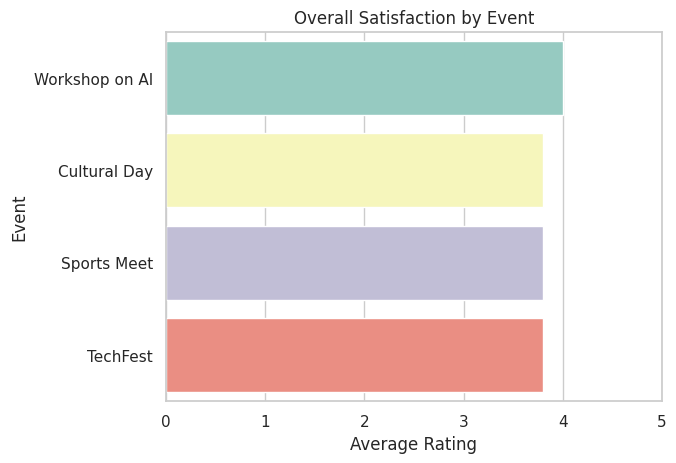

In [ ]:
if 'eventname' in df.columns:
    grp = df.groupby('eventname')[likert_cols + ['vader_compound']].mean().sort_values('overallsatisfaction', ascending=False)
    display(grp.round(2))

    plt.figure()
    sns.barplot(x='overallsatisfaction', y='eventname', data=grp.reset_index(), order=grp.index, palette="Set3")
    plt.title('Overall Satisfaction by Event')
    plt.xlabel('Average Rating'); plt.ylabel('Event')
    plt.xlim(0,5); plt.show()


   ii) Over time

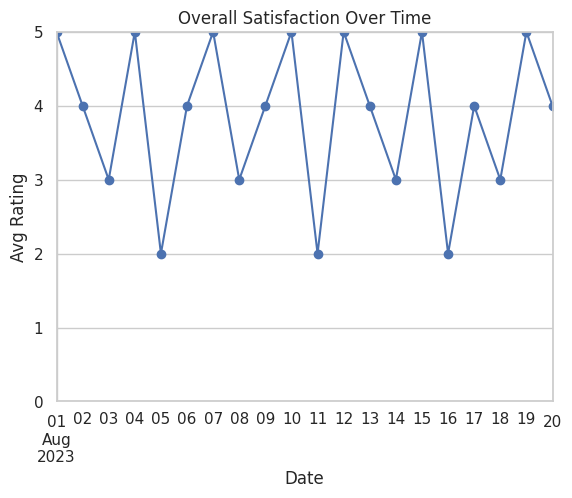

In [ ]:
time_col = 'eventdate' if 'eventdate' in df.columns else ('timestamp' if 'timestamp' in df.columns else None)
if time_col:
    daily = df.set_index(time_col).resample('D')[likert_cols + ['vader_compound']].mean()
    plt.figure()
    daily['overallsatisfaction'].plot(marker='o')
    plt.title('Overall Satisfaction Over Time'); plt.xlabel('Date'); plt.ylabel('Avg Rating')
    plt.ylim(0,5); plt.show()


 iii) Segment analysis (example: Department)

,overallsatisfaction,organization,speakers,activities,venue,food,vader_compound,vader_compound,vader_compound,vader_compound,vader_compound
department,,,,,,,,,,,
ECE,4.50,4.50,4.50,4.25,4.50,4.50,0.56,0.56,0.56,0.56,0.56
Civil,4.25,4.25,4.50,4.25,4.00,4.50,0.73,0.73,0.73,0.73,0.73
MBA,4.00,4.00,4.00,3.75,4.00,3.75,0.42,0.42,0.42,0.42,0.42
CSE,3.25,3.25,3.25,3.25,3.25,3.00,0.06,0.06,0.06,0.06,0.06
ME,3.25,3.25,3.00,3.25,3.25,2.75,0.09,0.09,0.09,0.09,0.09


/tmp/ipython-input-3587200576.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='overallsatisfaction', y='department', data=seg.reset_index(), order=seg.index, palette="Set1")


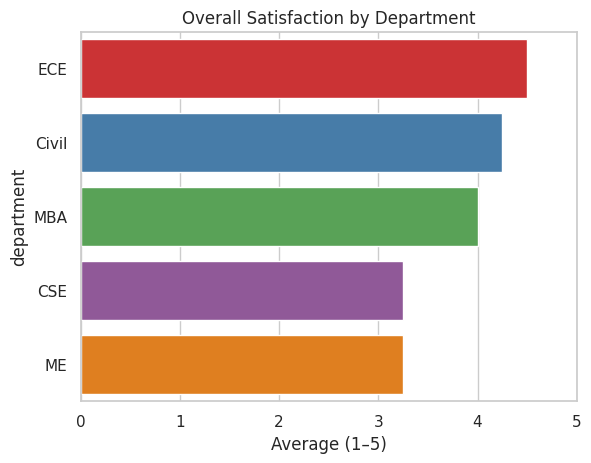

In [ ]:
if 'department' in df.columns:
    seg = (df.groupby('department')[likert_cols + ['vader_compound']]
           .mean().sort_values('overallsatisfaction', ascending=False).round(2))
    display(seg)

    plt.figure()
    sns.barplot(x='overallsatisfaction', y='department', data=seg.reset_index(), order=seg.index, palette="Set1")
    plt.title('Overall Satisfaction by Department'); plt.xlabel('Average (1–5)')
    plt.xlim(0,5); plt.show()


 * Final visuals

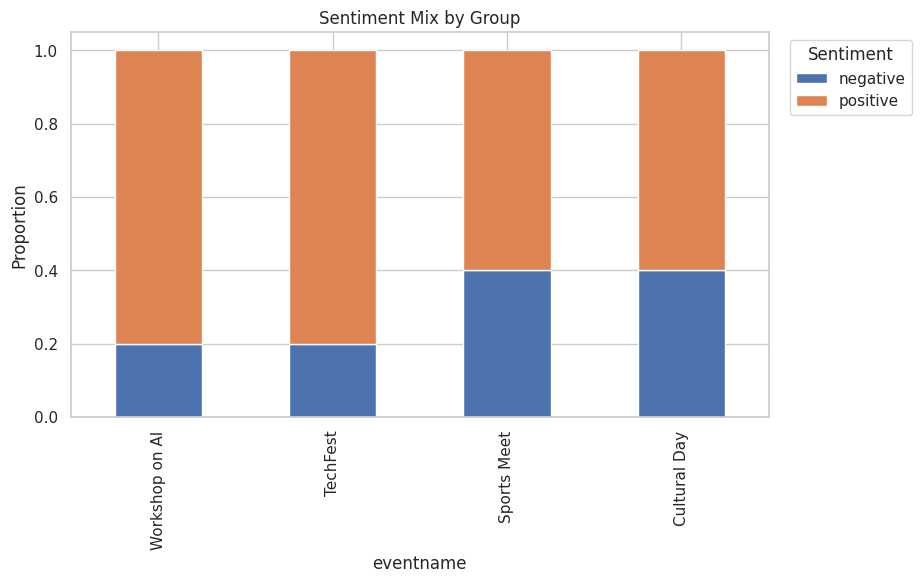

In [ ]:
sent_by_evt = None
if 'eventname' in df.columns:
    sent_by_evt = (df.pivot_table(index='eventname', columns='sentiment_vader', values='free_text', aggfunc='count', fill_value=0))
else:
    sent_by_evt = (df.pivot_table(index='department' if 'department' in df.columns else 'overallsatisfaction',
                                  columns='sentiment_vader', values='free_text', aggfunc='count', fill_value=0))

prop = (sent_by_evt.T / sent_by_evt.sum(axis=1)).T.reset_index().rename(columns={'index':'group'})
prop = prop.sort_values(by='positive', ascending=False)

prop.plot(kind='bar', stacked=True, x=prop.columns[0], figsize=(9,5))
plt.title('Sentiment Mix by Group')
plt.ylabel('Proportion'); plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


**8) Save cleaned dataset & charts**

In [ ]:
clean_path = 'clean_feedback.csv'
df.to_csv(clean_path, index=False)
print("Saved:", clean_path)


Saved: clean_feedback.csv


In [ ]:
# --- Step 10: Summary (basic insights) ---
print("Total responses:", len(df))
print("Average overall rating:", df['overallsatisfaction'].mean())
print("Sentiment counts:\n", df['Sentiment'].value_counts())

print("\nRecommendations Example:")
print("1. Improve logistics (common negative theme).")
print("2. Invite engaging speakers (positive mentions).")
print("3. Shorten event duration (negative trend).")

Total responses: 20
Average overall rating: 3.85
Sentiment counts:
 Sentiment
Positive    14
Negative     6
Name: count, dtype: int64

Recommendations Example:
1. Improve logistics (common negative theme).
2. Invite engaging speakers (positive mentions).
3. Shorten event duration (negative trend).
